# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.12KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

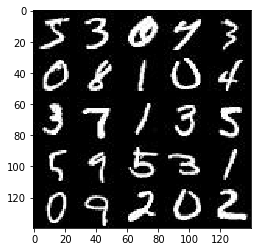

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

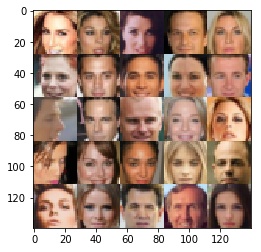

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [60]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                  name='real_input')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [61]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.01
        #Layer 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        #Layer 2
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.01 * batch_norm2, batch_norm2)

        #Layer 3
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.01 * batch_norm3, batch_norm3)

        #Layer 4
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [62]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """      
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.01
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        
        g2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='SAME')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [64]:
def model_opt(d_loss, g_loss, learning_rate, beta1=0.5):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [108]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode,print_every=10, 
          show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #build network
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2],
                                           data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for x in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

    return losses, samples     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3576... Generator Loss: 1.5239
Epoch 1/2... Discriminator Loss: 0.6968... Generator Loss: 4.4471
Epoch 1/2... Discriminator Loss: 0.3115... Generator Loss: 2.6168
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.5085
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.6069


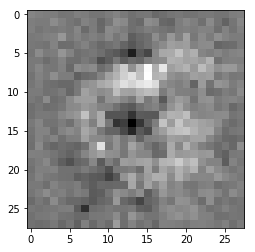

Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 0.9831
Epoch 1/2... Discriminator Loss: 1.1930... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 1.5525
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 2.3732
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 0.5076... Generator Loss: 2.1538
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 3.9401
Epoch 1/2... Discriminator Loss: 0.4241... Generator Loss: 3.5008


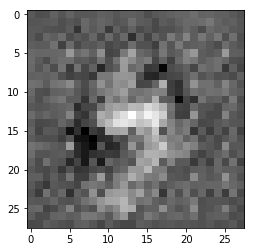

Epoch 1/2... Discriminator Loss: 0.4588... Generator Loss: 1.7882
Epoch 1/2... Discriminator Loss: 2.4218... Generator Loss: 4.5266
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 5.1818
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 1.7743
Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 2.0823
Epoch 1/2... Discriminator Loss: 0.2860... Generator Loss: 4.5453
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 0.2443... Generator Loss: 1.9923
Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.3914


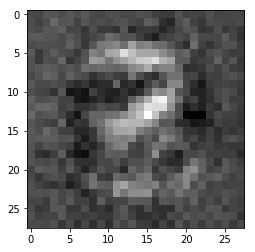

Epoch 1/2... Discriminator Loss: 0.1536... Generator Loss: 2.7514
Epoch 1/2... Discriminator Loss: 0.2470... Generator Loss: 2.3229
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 2.1814
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 10.4481
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 0.3191... Generator Loss: 1.6501
Epoch 1/2... Discriminator Loss: 0.0463... Generator Loss: 4.4554
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 0.1261... Generator Loss: 3.8936
Epoch 1/2... Discriminator Loss: 2.0493... Generator Loss: 0.2305


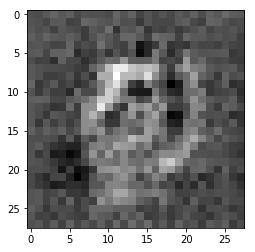

Epoch 1/2... Discriminator Loss: 0.1207... Generator Loss: 3.5843
Epoch 1/2... Discriminator Loss: 0.0800... Generator Loss: 5.6786
Epoch 1/2... Discriminator Loss: 0.0856... Generator Loss: 3.4567
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 6.1945
Epoch 1/2... Discriminator Loss: 0.1374... Generator Loss: 2.7725
Epoch 1/2... Discriminator Loss: 0.1224... Generator Loss: 4.8079
Epoch 1/2... Discriminator Loss: 0.0996... Generator Loss: 4.7454
Epoch 1/2... Discriminator Loss: 0.1891... Generator Loss: 3.2425
Epoch 1/2... Discriminator Loss: 0.0425... Generator Loss: 5.5899
Epoch 1/2... Discriminator Loss: 0.1528... Generator Loss: 2.7880


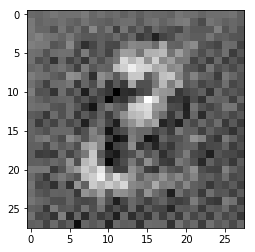

Epoch 1/2... Discriminator Loss: 0.0364... Generator Loss: 5.0102
Epoch 1/2... Discriminator Loss: 0.0975... Generator Loss: 5.8034
Epoch 1/2... Discriminator Loss: 0.0580... Generator Loss: 5.6129
Epoch 1/2... Discriminator Loss: 0.4346... Generator Loss: 11.8241
Epoch 1/2... Discriminator Loss: 0.0398... Generator Loss: 7.4385
Epoch 1/2... Discriminator Loss: 0.0564... Generator Loss: 5.3204
Epoch 1/2... Discriminator Loss: 0.2489... Generator Loss: 1.9545
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 6.3696
Epoch 1/2... Discriminator Loss: 0.0557... Generator Loss: 4.5340
Epoch 1/2... Discriminator Loss: 0.0844... Generator Loss: 6.6448


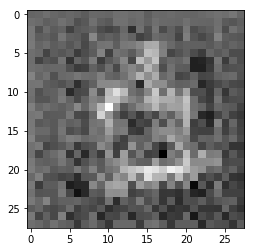

Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 0.2584... Generator Loss: 2.9266
Epoch 1/2... Discriminator Loss: 0.0983... Generator Loss: 3.3982
Epoch 1/2... Discriminator Loss: 0.1653... Generator Loss: 2.7037
Epoch 1/2... Discriminator Loss: 1.8362... Generator Loss: 8.5896
Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 0.0843... Generator Loss: 4.6649
Epoch 1/2... Discriminator Loss: 0.0360... Generator Loss: 8.2263
Epoch 1/2... Discriminator Loss: 0.0501... Generator Loss: 12.4560
Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 4.0845


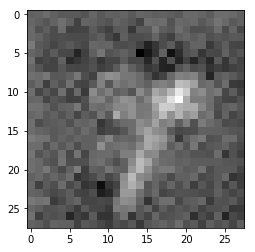

Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 4.3165
Epoch 1/2... Discriminator Loss: 0.0661... Generator Loss: 7.7526
Epoch 1/2... Discriminator Loss: 0.1243... Generator Loss: 8.3082
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 3.4874
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 0.1253... Generator Loss: 2.9673
Epoch 1/2... Discriminator Loss: 0.0673... Generator Loss: 12.6675
Epoch 1/2... Discriminator Loss: 0.0413... Generator Loss: 8.2859
Epoch 1/2... Discriminator Loss: 0.1170... Generator Loss: 2.7949


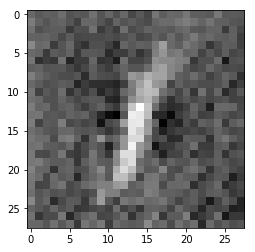

Epoch 1/2... Discriminator Loss: 0.1905... Generator Loss: 2.1710
Epoch 1/2... Discriminator Loss: 0.5023... Generator Loss: 1.1866
Epoch 1/2... Discriminator Loss: 0.1098... Generator Loss: 2.6461
Epoch 1/2... Discriminator Loss: 0.0889... Generator Loss: 2.8315
Epoch 1/2... Discriminator Loss: 0.0918... Generator Loss: 2.8540
Epoch 1/2... Discriminator Loss: 0.0214... Generator Loss: 6.8285
Epoch 1/2... Discriminator Loss: 3.4187... Generator Loss: 5.8705
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 0.2247... Generator Loss: 2.1320
Epoch 1/2... Discriminator Loss: 0.0383... Generator Loss: 4.3814


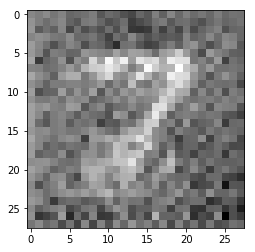

Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 0.0889... Generator Loss: 3.2901
Epoch 1/2... Discriminator Loss: 0.0234... Generator Loss: 8.7904
Epoch 1/2... Discriminator Loss: 0.0312... Generator Loss: 7.2541
Epoch 1/2... Discriminator Loss: 0.1893... Generator Loss: 2.1147
Epoch 1/2... Discriminator Loss: 0.0597... Generator Loss: 9.4223
Epoch 1/2... Discriminator Loss: 0.0494... Generator Loss: 4.2963
Epoch 1/2... Discriminator Loss: 0.2144... Generator Loss: 1.9215
Epoch 1/2... Discriminator Loss: 0.0252... Generator Loss: 5.5129
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 4.7482


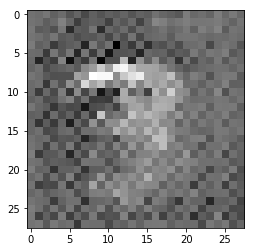

Epoch 1/2... Discriminator Loss: 0.0900... Generator Loss: 4.9789
Epoch 1/2... Discriminator Loss: 0.0081... Generator Loss: 6.5369
Epoch 1/2... Discriminator Loss: 0.0219... Generator Loss: 8.4569
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 10.4699
Epoch 1/2... Discriminator Loss: 0.0204... Generator Loss: 5.6074
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.1106
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 5.2399
Epoch 2/2... Discriminator Loss: 0.3879... Generator Loss: 1.6188
Epoch 2/2... Discriminator Loss: 0.2774... Generator Loss: 1.8542
Epoch 2/2... Discriminator Loss: 0.1207... Generator Loss: 2.8468


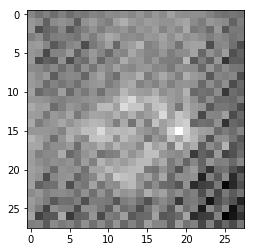

Epoch 2/2... Discriminator Loss: 0.0334... Generator Loss: 9.5041
Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 5.0584
Epoch 2/2... Discriminator Loss: 0.1733... Generator Loss: 2.3477
Epoch 2/2... Discriminator Loss: 0.0467... Generator Loss: 12.6801
Epoch 2/2... Discriminator Loss: 0.0622... Generator Loss: 3.4539
Epoch 2/2... Discriminator Loss: 0.1497... Generator Loss: 2.6520
Epoch 2/2... Discriminator Loss: 0.2361... Generator Loss: 14.4518
Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 1.4327
Epoch 2/2... Discriminator Loss: 0.1868... Generator Loss: 2.0112
Epoch 2/2... Discriminator Loss: 0.0444... Generator Loss: 4.0426


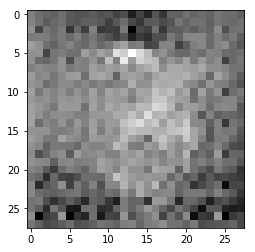

Epoch 2/2... Discriminator Loss: 0.0367... Generator Loss: 3.8135
Epoch 2/2... Discriminator Loss: 0.1675... Generator Loss: 2.3910
Epoch 2/2... Discriminator Loss: 0.1866... Generator Loss: 2.2472
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 0.0218... Generator Loss: 8.6614
Epoch 2/2... Discriminator Loss: 0.0954... Generator Loss: 3.4699
Epoch 2/2... Discriminator Loss: 0.3280... Generator Loss: 1.8049
Epoch 2/2... Discriminator Loss: 0.0328... Generator Loss: 4.4765
Epoch 2/2... Discriminator Loss: 0.1006... Generator Loss: 4.5703
Epoch 2/2... Discriminator Loss: 0.0167... Generator Loss: 10.2803


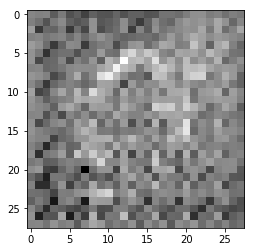

Epoch 2/2... Discriminator Loss: 0.0708... Generator Loss: 3.5836
Epoch 2/2... Discriminator Loss: 0.1822... Generator Loss: 2.6810
Epoch 2/2... Discriminator Loss: 0.0344... Generator Loss: 7.4995
Epoch 2/2... Discriminator Loss: 0.1637... Generator Loss: 2.3101
Epoch 2/2... Discriminator Loss: 0.0241... Generator Loss: 4.9403
Epoch 2/2... Discriminator Loss: 0.0989... Generator Loss: 3.5508
Epoch 2/2... Discriminator Loss: 0.1317... Generator Loss: 2.7005
Epoch 2/2... Discriminator Loss: 0.0244... Generator Loss: 5.9776
Epoch 2/2... Discriminator Loss: 0.0350... Generator Loss: 4.3540
Epoch 2/2... Discriminator Loss: 0.1613... Generator Loss: 2.4928


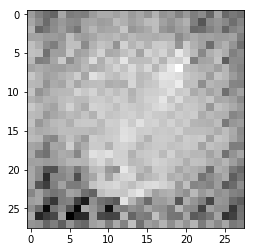

Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 4.0745
Epoch 2/2... Discriminator Loss: 0.0845... Generator Loss: 3.0390
Epoch 2/2... Discriminator Loss: 0.0158... Generator Loss: 6.8443
Epoch 2/2... Discriminator Loss: 0.0151... Generator Loss: 10.3852
Epoch 2/2... Discriminator Loss: 0.0039... Generator Loss: 13.3038
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 13.1264
Epoch 2/2... Discriminator Loss: 0.0387... Generator Loss: 10.3189
Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 2.6752
Epoch 2/2... Discriminator Loss: 1.6833... Generator Loss: 0.3289
Epoch 2/2... Discriminator Loss: 0.2082... Generator Loss: 2.3310


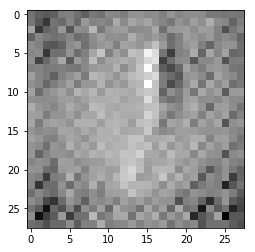

Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 4.4753
Epoch 2/2... Discriminator Loss: 1.5418... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 0.0338... Generator Loss: 6.8496
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 10.4231
Epoch 2/2... Discriminator Loss: 0.0521... Generator Loss: 4.3785
Epoch 2/2... Discriminator Loss: 0.3622... Generator Loss: 1.6389
Epoch 2/2... Discriminator Loss: 0.0483... Generator Loss: 5.2126
Epoch 2/2... Discriminator Loss: 0.0416... Generator Loss: 6.8337
Epoch 2/2... Discriminator Loss: 0.0300... Generator Loss: 9.2417
Epoch 2/2... Discriminator Loss: 0.0581... Generator Loss: 4.5255


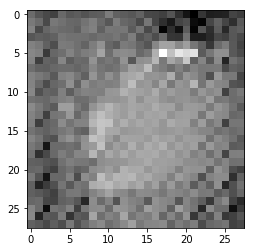

Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 11.9427
Epoch 2/2... Discriminator Loss: 0.0293... Generator Loss: 4.7029
Epoch 2/2... Discriminator Loss: 0.0145... Generator Loss: 5.7517
Epoch 2/2... Discriminator Loss: 0.2960... Generator Loss: 1.6595
Epoch 2/2... Discriminator Loss: 0.3363... Generator Loss: 1.6030
Epoch 2/2... Discriminator Loss: 0.2112... Generator Loss: 2.2122
Epoch 2/2... Discriminator Loss: 0.1392... Generator Loss: 2.4247
Epoch 2/2... Discriminator Loss: 0.1991... Generator Loss: 2.3940
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.0920
Epoch 2/2... Discriminator Loss: 0.0518... Generator Loss: 4.9902


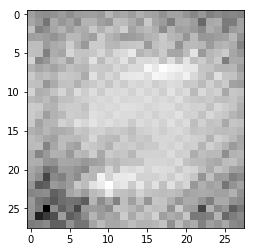

Epoch 2/2... Discriminator Loss: 0.0683... Generator Loss: 3.3733
Epoch 2/2... Discriminator Loss: 0.0061... Generator Loss: 13.8203
Epoch 2/2... Discriminator Loss: 0.0113... Generator Loss: 8.1873
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.5609
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.1988
Epoch 2/2... Discriminator Loss: 0.1047... Generator Loss: 3.4510
Epoch 2/2... Discriminator Loss: 0.1588... Generator Loss: 2.9504
Epoch 2/2... Discriminator Loss: 0.5296... Generator Loss: 5.1015
Epoch 2/2... Discriminator Loss: 1.6737... Generator Loss: 0.3966
Epoch 2/2... Discriminator Loss: 0.0817... Generator Loss: 13.1815


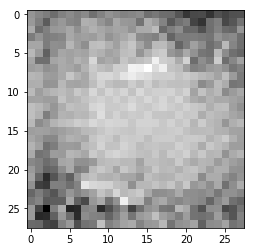

Epoch 2/2... Discriminator Loss: 0.0410... Generator Loss: 5.1122
Epoch 2/2... Discriminator Loss: 0.0361... Generator Loss: 14.4313
Epoch 2/2... Discriminator Loss: 0.4544... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 0.1990... Generator Loss: 2.6711
Epoch 2/2... Discriminator Loss: 0.0318... Generator Loss: 12.0005
Epoch 2/2... Discriminator Loss: 0.1511... Generator Loss: 8.0371
Epoch 2/2... Discriminator Loss: 0.0247... Generator Loss: 13.5854
Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 4.2454
Epoch 2/2... Discriminator Loss: 0.0156... Generator Loss: 5.9820
Epoch 2/2... Discriminator Loss: 0.1641... Generator Loss: 2.5163


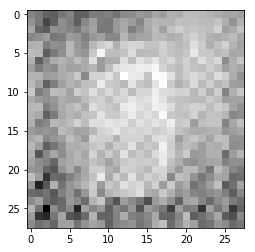

Epoch 2/2... Discriminator Loss: 0.0984... Generator Loss: 7.9207
Epoch 2/2... Discriminator Loss: 0.4461... Generator Loss: 15.3214
Epoch 2/2... Discriminator Loss: 0.2440... Generator Loss: 14.2349
Epoch 2/2... Discriminator Loss: 0.6154... Generator Loss: 1.0060
Epoch 2/2... Discriminator Loss: 0.0167... Generator Loss: 7.3072
Epoch 2/2... Discriminator Loss: 0.0166... Generator Loss: 5.5340
Epoch 2/2... Discriminator Loss: 0.1089... Generator Loss: 10.8599
Epoch 2/2... Discriminator Loss: 0.0104... Generator Loss: 9.4920
Epoch 2/2... Discriminator Loss: 0.2156... Generator Loss: 2.2816
Epoch 2/2... Discriminator Loss: 0.0168... Generator Loss: 9.5903


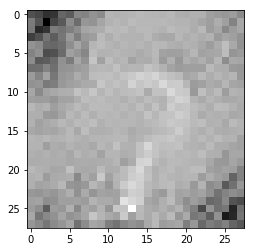

Epoch 2/2... Discriminator Loss: 0.1392... Generator Loss: 3.3478
Epoch 2/2... Discriminator Loss: 0.0145... Generator Loss: 6.4278
Epoch 2/2... Discriminator Loss: 0.0224... Generator Loss: 4.4147
Epoch 2/2... Discriminator Loss: 0.0081... Generator Loss: 7.1796
Epoch 2/2... Discriminator Loss: 0.0306... Generator Loss: 5.3652
Epoch 2/2... Discriminator Loss: 0.0153... Generator Loss: 6.1607
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 0.4197
Epoch 2/2... Discriminator Loss: 0.0193... Generator Loss: 11.4835
Epoch 2/2... Discriminator Loss: 0.0356... Generator Loss: 10.6545
Epoch 2/2... Discriminator Loss: 0.0279... Generator Loss: 5.2202


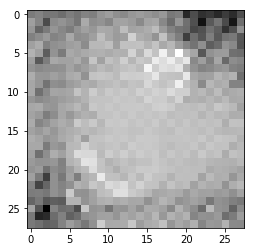

Epoch 2/2... Discriminator Loss: 0.0488... Generator Loss: 11.8018
Epoch 2/2... Discriminator Loss: 0.2415... Generator Loss: 2.3176
Epoch 2/2... Discriminator Loss: 0.0647... Generator Loss: 5.6773
Epoch 2/2... Discriminator Loss: 0.2094... Generator Loss: 2.6813


In [109]:
batch_size = 56
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 1.1219


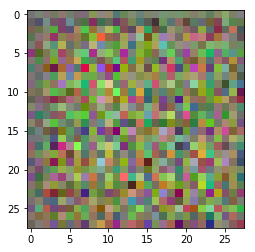

Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.4404
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 1.4645


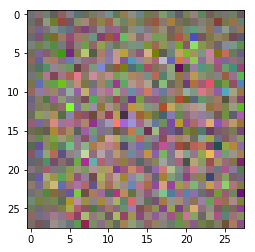

Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.4828
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 1.5241
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 1.6569
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 1.5346
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 1.6917
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 1.6985


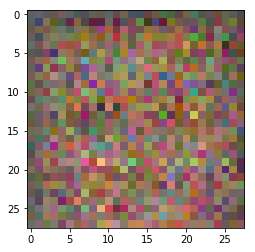

Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 1.8950
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 1.7283
Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 1.7341
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.7945
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 1.8695


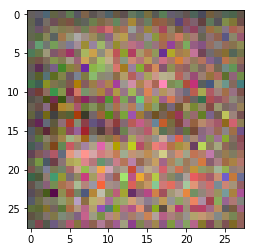

Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 2.0635
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 1.6541
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 1.7754
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 1.9223
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 1.8308
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 1.8136
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 1.9903
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 1.7114


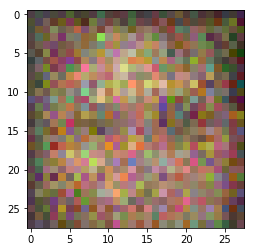

Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 1.7637
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.7346
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 1.7483
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 1.7770
Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 1.8828
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 1.7291
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 1.9732
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 1.6185


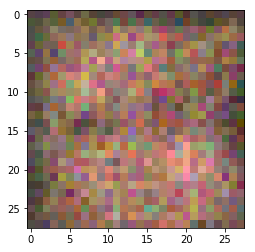

Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.6290
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 1.6241
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.5792
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.4809
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 1.6275


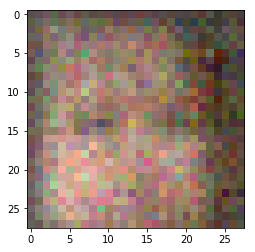

Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 1.6482
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 1.6394
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 1.6459
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 1.7473
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 1.8188


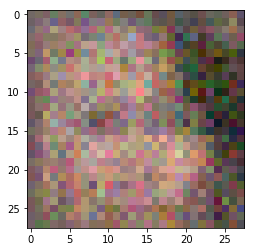

Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 1.6597
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 1.7295
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 1.8011
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.6925
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 1.8922


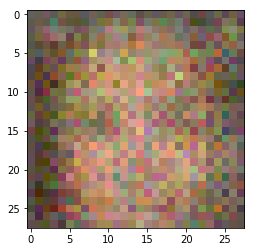

Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 1.7149
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.7659
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 1.8109
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 1.6677
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 1.8061
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 1.7549
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 1.4928
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 1.6159


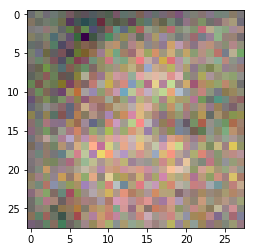

Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 1.9495
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 1.6680
Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 1.6333
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 1.6805
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 1.7852
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 1.6992


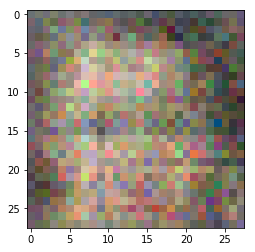

Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 1.6020
Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 1.5659
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.6357
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 1.6142
Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 1.5100
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.2853


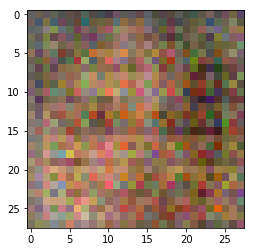

Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 1.7077
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.4444
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.3604
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.5466
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 1.5883
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.1702


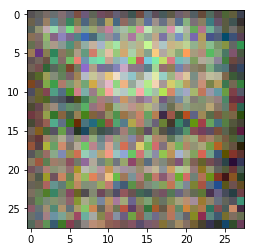

Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 1.4998
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.5346
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.3112
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.5630


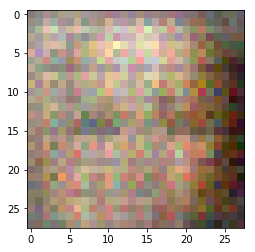

Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.8801


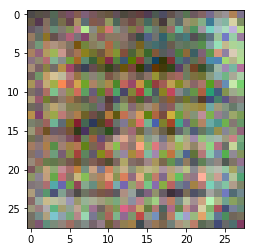

Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.2368
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.2194
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.1898


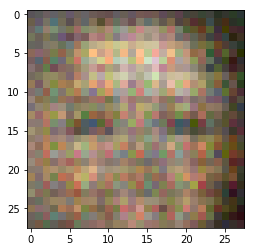

Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.1278


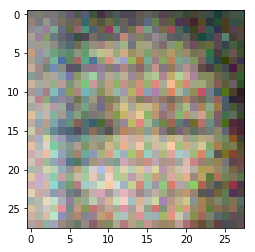

Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.0607


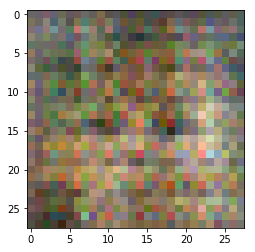

Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.1403


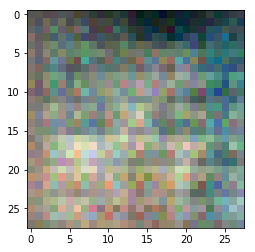

Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.0997


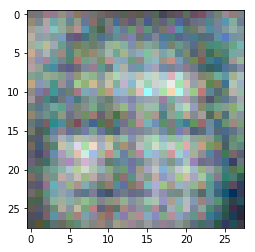

Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.1428


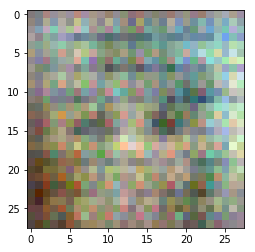

Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.0294


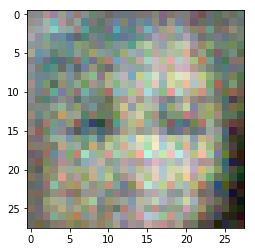

Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.1282


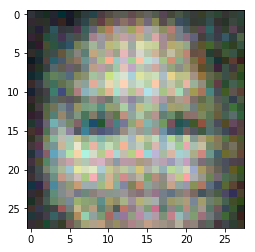

Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.1993


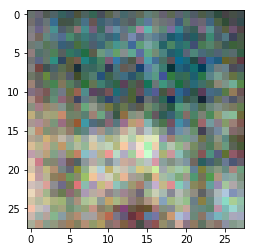

Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.0636


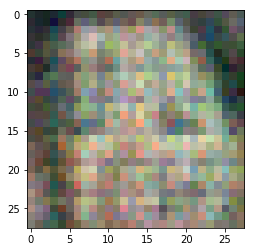

Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.0223


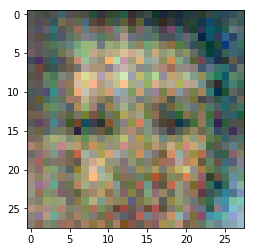

Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 1.1276


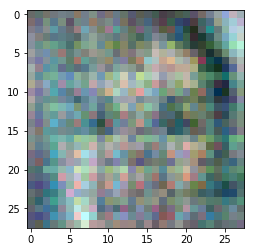

Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.9447


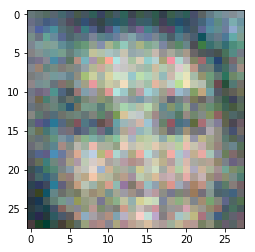

Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.2192


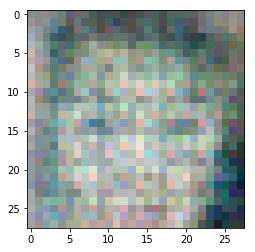

Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.2030


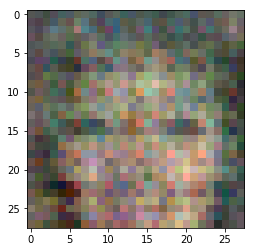

Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.0121


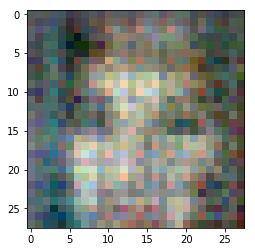

Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9785


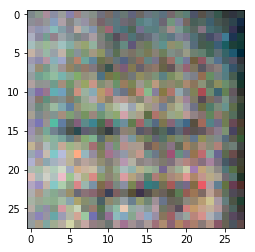

Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.0703


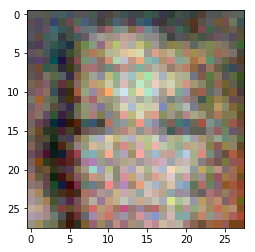

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.8111


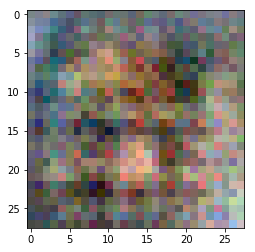

Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.0237


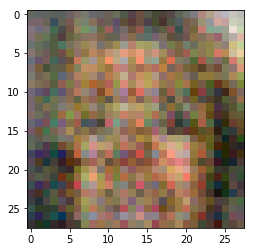

Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.1484


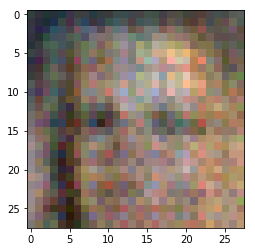

Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.0208


In [103]:
batch_size = 56
z_dim = 100
learning_rate = 0.00001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.